In [ ]:
import argparse
import os
import sys 
sys.path.insert(0, '/raven/u/noka/VAEEG')  # or use relative: os.path.abspath('..')
from src.model.opts.dataset import ClipDataset
from src.model.net.old_modelA import VAEEG, re_parameterize
import yaml
import torch
import numpy as np
from collections import OrderedDict
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def load_model(model: nn.Module, ckpt_file: str):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(ckpt_file, map_location=device)
    sd = ckpt["model"]

    # Remove "module.", if saved under DataParallel/DDP"
    if next(iter(sd)).startswith("module."):
        sd = {k[len("module."):]: v for k, v in sd.items()}
    model.load_state_dict(sd)
    model.to(device)
    
    return device

In [3]:
def init_model(in_channels, z_dim, deterministic, ckpt_file, negative_slope=0.2, decoder_last_lstm=False): 
    model = VAEEG(in_channels=in_channels,
                    z_dim=z_dim,
                    negative_slope=negative_slope,
                    decoder_last_lstm=decoder_last_lstm,
                    deterministic=deterministic)
    device = load_model(model, ckpt_file=ckpt_file)
    return model, device

In [4]:
def init_dl(data_root, band, batch_size=1024, num_workers=1, shuffle=False): 
    ds = ClipDataset(
        data_dir=data_root,
        band_name=band,
        clip_len=256
    )
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )
    return loader

In [5]:
def get_latent(model, loader, device, z_dim):
    model.eval()
    num_samples = len(loader.dataset)
    z_arr = np.zeros((num_samples, z_dim), dtype=np.float32)  
    idx = 0
    encoder = model.module.encoder if hasattr(model, 'module') else model.encoder
    # Get the deterministic setting from the model
    deterministic = model.module.deterministic if hasattr(model, 'module') else model.deterministic
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            mu, log_var = encoder(x)
            if deterministic:
                z_batch = mu  
            else:
                z_batch = re_parameterize(mu, log_var, deterministic=deterministic)
            bs = z_batch.size(0)
            z_arr[idx:idx + bs, :] = z_batch.cpu().numpy()
            idx += bs
    return z_arr

In [15]:
# Define model parameters
bands = ["delta", "theta", "alpha", "low_beta", "high_beta"]
z_dim = 50
epoch = 50
in_channels=1
seed = 42 
deterministic = False
if deterministic: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/vanilla"
else: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/variational"
data_dir = "/ptmp/noka/new_data/"

In [7]:
# Dictionaries for latents
ae_latents = {} 
vae_latents = {}
pca_latents = {}
pca_train = {}
pca_test = {}

In [10]:
# Prepare data for PCA fitting
rng_test = np.random.RandomState(seed)
starts_test = rng_test.randint(0, 1280 - 256 + 1, size=288182)
rng_train = np.random.RandomState(seed)
starts_train = rng_train.randint(0, 1280 - 256 + 1, size=2575060)
for band in tqdm(bands): 
    band_train = np.load(os.path.join(data_dir, "train", f"{band}.npy"))
    band_test = np.load(os.path.join(data_dir, "test", f"{band}.npy"))
    orig_train = np.zeros((band_train.shape[0], 256), dtype=band_train.dtype)
    orig_test = np.zeros((band_test.shape[0], 256), dtype=band_test.dtype)
    for i in range(band_train.shape[0]):
        orig_train[i] = band_train[i, starts_train[i]:starts_train[i] + 256]
    for i in range(band_test.shape[0]):
        orig_test[i] = band_test[i, starts_test[i]:starts_test[i] + 256]
    pca_train[band] = orig_train
    pca_test[band] = orig_test

100%|██████████| 5/5 [01:46<00:00, 21.31s/it]


In [16]:
# Get AE and VAE latents
for band in tqdm(bands):
    ckpt_file = os.path.join(ckpt_root, band, f"z{z_dim}", f"ckpt_epoch_{epoch}.ckpt")
    model, device = init_model(in_channels=in_channels, z_dim=z_dim, deterministic=deterministic, ckpt_file=ckpt_file)
    loader = init_dl(os.path.join(data_dir, "test"), band)
    latent = get_latent(model=model, loader=loader, device=device, z_dim=z_dim)
    if deterministic: 
        ae_latents[band] = latent
    else: 
        vae_latents[band] = latent

100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


In [11]:
# Get PCA latents
pca_components = {}
for band in tqdm(bands):
    data_train = pca_train[band]   
    pca = PCA(n_components=50, random_state=42)
    pca.fit(data_train)
    pca_components[band] = pca.components_
    print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))
    data_test = pca_test[band]     
    latents = pca.transform(data_test)
    pca_latents[band] = latents

 20%|██        | 1/5 [00:00<00:02,  1.67it/s]

Explained variance ratio sum: 0.99999994


 40%|████      | 2/5 [00:01<00:01,  1.67it/s]

Explained variance ratio sum: 1.0


 60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Explained variance ratio sum: 0.9999999


 80%|████████  | 4/5 [00:02<00:00,  1.68it/s]

Explained variance ratio sum: 0.9999999


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

Explained variance ratio sum: 1.0


In [54]:
X = pca_latents["high_beta"]
y = np.load("/ptmp/noka/labels/test.npy")
X0 = X[y == 0]
X1 = X[y == 1]
n0, n1 = len(X0), len(X1)
n = n0 + n1

# means
mu0 = X0.mean(axis=0)
mu1 = X1.mean(axis=0)
mu  = X.mean(axis=0)

# within-class scatter 
S0 = (X0 - mu0).T @ (X0 - mu0)   
S1 = (X1 - mu1).T @ (X1 - mu1)   
SW = S0 + S1


SB = n0 * np.outer(mu0 - mu, mu0 - mu) + n1 * np.outer(mu1 - mu, mu1 - mu)

# traces (total variances)
tr_S0 = np.trace(S0)
tr_S1 = np.trace(S1)
tr_SW = np.trace(SW)
tr_SB = np.trace(SB)

ratio = tr_SB / tr_SW
print(f"{ratio * 1000:.3f}")

0.002


In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
band = "high_beta"
lda = LinearDiscriminantAnalysis(n_components=1, store_covariance=True)
lda.fit(ae_latents[band], labels)
mu0, mu1 = lda.means_
d = mu1 - mu0
W = lda.covariance_
J_star = d @ np.linalg.inv(W) @ d
print("Fisher's J*:", J_star)

Fisher's J*: 100465.28370017558


In [26]:
# extract seizure and background indices
labels = np.load("/ptmp/noka/labels/test.npy")
seiz_indices = np.where(labels == 1)[0]
bkgd_indices = np.where(labels == 0)[0]

In [45]:
seiz = vae_latents["low_beta"][seiz_indices]
bkgd = vae_latents["low_beta"][bkgd_indices]
all_latents = np.vstack((seiz, bkgd))

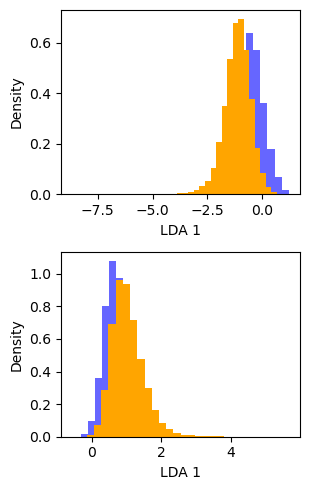

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
band = "theta"
fig, axes = plt.subplots(2, 1, figsize=(3.2, 5))
lda = LinearDiscriminantAnalysis(n_components=1)
z = lda.fit_transform(ae_latents[band], labels).ravel()
axes[0].hist(z[labels==0], bins=30, color="blue", alpha=0.6, label="Background", density=True)
axes[0].hist(z[labels==1], bins=30, color="orange", label="Seizure", density=True)
axes[0].set_xlabel("LDA 1")
axes[0].set_ylabel("Density")

band = "delta"
lda = LinearDiscriminantAnalysis(n_components=1)
z = lda.fit_transform(ae_latents[band], labels).ravel()
axes[1].hist(z[labels==0], bins=30, color="blue", alpha=0.6, label="Background", density=True)
axes[1].hist(z[labels==1], bins=30, color="orange", label="Seizure", density=True)
axes[1].set_xlabel("LDA 1")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.savefig("lda_ae.pdf")
plt.show()

In [54]:
m1 = z[labels==0].mean()
m2 = z[labels==1].mean()
s1 = z[labels==0].var(ddof=1)
s2 = z[labels==1].var(ddof=1)

J_1d = (m1 - m2)**2 / (s1 + s2)
print("Fisher Discriminant Constant (1D form):", J_1d)

Fisher Discriminant Constant (1D form): 0.16759960471093371


In [55]:
X1 = vae_latents["delta"][labels == 0]
X2 = vae_latents["delta"][labels == 1]
mu1 = X1.mean(axis=0)
mu2 = X2.mean(axis=0)


w = lda.coef_.ravel()
# Scatter matrices
S_W = (X1 - mu1).T @ (X1 - mu1) + (X2 - mu2).T @ (X2 - mu2)
mean_diff = (mu1 - mu2).reshape(-1, 1)
S_B = mean_diff @ mean_diff.T

# Fisher criterion
num = float(S_B)
den = float(S_W)
J = num / den

print("Fisher Discriminant Constant J(w*):", J)

TypeError: only size-1 arrays can be converted to Python scalars

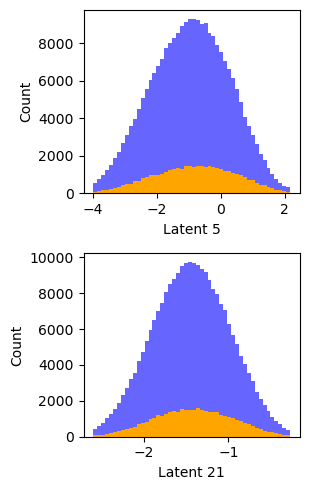

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(3.2, 5))

# First latent
i = 5
lo, hi = np.percentile(np.concatenate([bkgd[:, i], seiz[:, i]]), [0.5, 99.5])
axes[0].hist(bkgd[:, i], bins=50, range=(lo, hi), color="blue", alpha=0.6, label="Background")
axes[0].hist(seiz[:, i], bins=50, range=(lo, hi), color="orange", label="Seizure")
axes[0].set_xlabel(f"Latent {i}")
axes[0].set_ylabel("Count")

# Second latent
i = 21
lo, hi = np.percentile(np.concatenate([bkgd[:, i], seiz[:, i]]), [0.5, 99.5])
axes[1].hist(bkgd[:, i], bins=50, range=(lo, hi), color="blue", alpha=0.6, label="Background")
axes[1].hist(seiz[:, i], bins=50, range=(lo, hi), color="orange", label="Seizure")
axes[1].set_xlabel(f"Latent {i}")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("seizure_vs_background_pca.pdf")
plt.show()

In [102]:
for band in bands: 
    seiz = pca_latents[band][seiz_indices]
    bkgd = pca_latents[band][bkgd_indices]
    n_seizure    = seiz.shape[0]
    n_background = bkgd.shape[0]

    subset_size = n_seizure // 2
    n_iters     = 10000
    rng         = np.random.default_rng(seed)

    dists_within_bg = np.zeros(n_iters)
    dists_within_sz = np.zeros(n_iters)
    subset_dists = np.zeros(n_iters)

    # Compute distances between means of two random subsets in BACKGROUND —
    for i in tqdm(range(n_iters)):
        # pick two disjoint random subsets of size `subset_size`
        idx1 = rng.choice(n_background, size=subset_size, replace=False)
        idx2 = rng.choice(n_background, size=subset_size, replace=False)
        m1   = bkgd[idx1].mean(axis=0)
        m2   = bkgd[idx2].mean(axis=0)
        dists_within_bg[i] = np.linalg.norm(m1 - m2)

    # Compute distances between means of two random subsets in SEIZURE —
    for i in tqdm(range(n_iters)):
        idx1 = rng.choice(n_seizure, size=subset_size, replace=False)
        idx2 = rng.choice(n_seizure, size=subset_size, replace=False)
        m1   = seiz[idx1].mean(axis=0)
        m2   = seiz[idx2].mean(axis=0)
        dists_within_sz[i] = np.linalg.norm(m1 - m2)

    # Compute distances between means across both 
    for i in tqdm(range(n_iters)):
        idx_s = rng.choice(n_seizure,    size=subset_size, replace=False)
        idx_b = rng.choice(n_background, size=subset_size, replace=False)
        m_s   = seiz[idx_s].mean(axis=0)
        m_b   = bkgd[idx_b].mean(axis=0)
        subset_dists[i] = np.linalg.norm(m_s - m_b)

    print(f"{dists_within_sz.mean():.3f}, {dists_within_bg.mean():.3f}, {subset_dists.mean():.3f}")
    # fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

    # Background histogram
    # axes[0].hist(dists_within_bg, bins=50, alpha=0.75, edgecolor='black')
    # axes[0].set_title('Within-Background')
    # axes[0].grid(True)

    # Seizure histogram
    # axes[1].hist(dists_within_sz, bins=50, alpha=0.75, edgecolor='black')
    # axes[1].set_title('Within-Seizure')

    # Both histogram 
    # axes[2].hist(subset_dists, bins=50, alpha=0.75, edgecolor='black')
    
    # axes[2].set_title('Between')

    # plt.tight_layout()
    # plt.show()

100%|██████████| 10000/10000 [00:32<00:00, 307.47it/s]


1.659, 1.821, 2.138


100%|██████████| 10000/10000 [00:32<00:00, 309.60it/s]


0.949, 0.972, 1.306


100%|██████████| 10000/10000 [00:32<00:00, 310.26it/s]


0.667, 0.818, 0.913


100%|██████████| 10000/10000 [00:34<00:00, 293.87it/s]


0.584, 1.301, 1.090


100%|██████████| 10000/10000 [00:33<00:00, 296.71it/s]

0.628, 0.863, 0.836


In [101]:
print(f"{dists_within_sz.mean():.3f}, {dists_within_bg.mean():.3f}, {subset_dists.mean():.3f}")

0.949, 0.972, 1.306


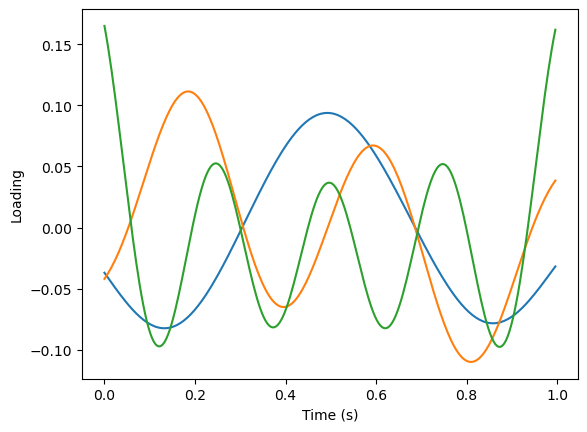

In [39]:
idx = [0, 3, 7]
time = np.arange(256) / 256
for i in idx: 
    plt.plot(time, pca_components["delta"][i, :].T)
plt.xlabel("Time (s)")
plt.ylabel("Loading")
plt.savefig("loadings_delta.pdf")
plt.show()

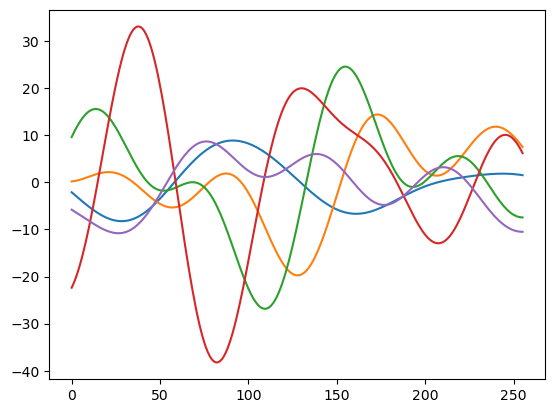

In [39]:
for i in range(5):
    plt.plot(pca_train["delta"][i])
plt.show()

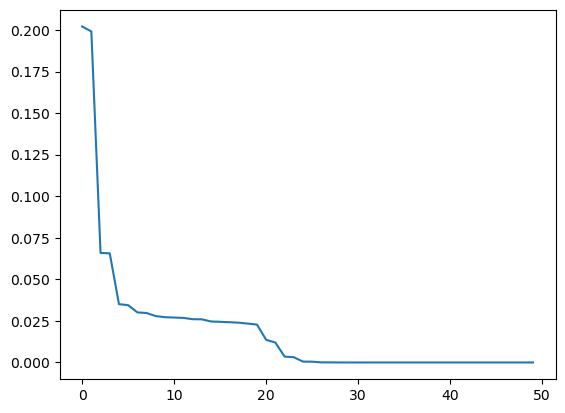

In [34]:
plt.plot(pca.explained_variance_ratio_)